# Setup

In [1]:
from helper import setup_data, utils, plot, engine
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
from torchinfo import summary
import timm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model

In [3]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [4]:
weights = torchvision.models.ConvNeXt_Large_Weights.DEFAULT
weights

ConvNeXt_Large_Weights.IMAGENET1K_V1

The auto-transformations can be taken from the weights.

In [5]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Data

In [6]:
train_loader, valid_loader, test_loader, test_data = setup_data.get_data_loaders(auto_transforms, auto_transforms, batch_size=32)

In [7]:
classes, class_to_idx, idx_to_class = setup_data.get_metadata(test_data)

In [8]:
train_loader, valid_loader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7f0a5a7c1350>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'ho

In [9]:
model = torchvision.models.convnext_large(weights=weights).to(device)

In [10]:
summary(model=model,
        input_size=(32, 3, 232, 232),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 232, 232]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 232, 232]    [32, 1536, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 232, 232]    [32, 192, 58, 58]    --                   True
│    │    └─Conv2d (0)                                  [32, 3, 232, 232]    [32, 192, 58, 58]    9,408                True
│    │    └─LayerNorm2d (1)                             [32, 192, 58, 58]    [32, 192, 58, 58]    384                  True
│    └─Sequential (1)                                   [32, 192, 58, 58]    [32, 192, 58, 58]    --                   True
│    │    └─CNBlock (0)                                 [32, 192, 58, 58]    [32, 192, 58, 58]    306,048              True
│  

In [11]:
# Freeze all base layers in the "features" section
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
model.classifier

Sequential(
  (0): LayerNorm2d((1536,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1536, out_features=1000, bias=True)
)

In [13]:
# From torchvision source code
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

In [14]:
output_shape = len(classes)

model.classifier = nn.Sequential(
    LayerNorm2d([1536,], eps=1e-6, elementwise_affine=True),
    nn.Flatten(),
    nn.Linear(1536, 101))

In [15]:
summary(model=model,
        input_size=(32, 3, 232, 232),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 232, 232]    [32, 101]            --                   Partial
├─Sequential (features)                                 [32, 3, 232, 232]    [32, 1536, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 232, 232]    [32, 192, 58, 58]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 232, 232]    [32, 192, 58, 58]    (9,408)              False
│    │    └─LayerNorm2d (1)                             [32, 192, 58, 58]    [32, 192, 58, 58]    (384)                False
│    └─Sequential (1)                                   [32, 192, 58, 58]    [32, 192, 58, 58]    --                   False
│    │    └─CNBlock (0)                                 [32, 192, 58, 58]    [32, 192, 58, 58]    (306,048)            

# Training

In [16]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=3)
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=output_shape).to(device)


In [18]:
engine.train?

Signature:
engine.train(
    model: torch.nn.modules.module.Module,
    train_loader: torch.utils.data.dataloader.DataLoader,
    valid_loader: torch.utils.data.dataloader.DataLoader,
    loss_fn: torch.nn.modules.module.Module,
    optimizer: torch.optim.optimizer.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    accuracy_fn: torchmetrics.classification.accuracy.Accuracy,
    device: torch.device,
    epochs: int,
    threshold: List[float],
) -> Dict[str, List[torch.Tensor]]
Docstring:
Trains the model and evaluates it on the validation set.

Args:
    model (torch.nn.Module): Model to be trained
    train_loader (torch.utils.data.DataLoader): Training data loader
    valid_loader (torch.utils.data.DataLoader): Validation data loader
    loss_fn (torch.nn.Module): Loss function
    optimizer (torch.optim.Optimizer): Optimizer
    scheduler (torch.optim.lr_scheduler.LRScheduler): Learning rate scheduler
    accuracy_fn (torchmetrics.Accuracy): Accuracy function
    d

In [19]:
results = engine.train(model,
                       train_loader,
                       valid_loader,
                       loss_fn,
                       optimizer,
                       scheduler,
                       accuracy_fn,
                       device,
                       epochs=3,
                       threshold=[1e-4])

  0%|          | 0/3 [00:00<?, ?it/s]

Training model::   0%|          | 0/2218 [00:00<?, ?it/s]

Train loss: 2.78624 | Train accuracy: 0.42


Making predictions::   0%|          | 0/1038 [00:00<?, ?it/s]

Test loss: 1.80783 | Test accuracy: 0.59
Epoch 1 of 3
-------------------------------
Train loss: 2.78624 | Train accuracy: 0.4175
Valid loss: 1.80783 | Valid accuracy: 0.5925


Training model::   0%|          | 0/2218 [00:00<?, ?it/s]

Train loss: 1.69878 | Train accuracy: 0.61


Making predictions::   0%|          | 0/1038 [00:00<?, ?it/s]

Test loss: 1.41203 | Test accuracy: 0.66
Epoch 2 of 3
-------------------------------
Train loss: 1.69878 | Train accuracy: 0.6074
Valid loss: 1.41203 | Valid accuracy: 0.6577


Training model::   0%|          | 0/2218 [00:00<?, ?it/s]

Train loss: 1.42681 | Train accuracy: 0.65


Making predictions::   0%|          | 0/1038 [00:00<?, ?it/s]

Test loss: 1.24064 | Test accuracy: 0.69
Epoch 3 of 3
-------------------------------
Train loss: 1.42681 | Train accuracy: 0.6546
Valid loss: 1.24064 | Valid accuracy: 0.6907


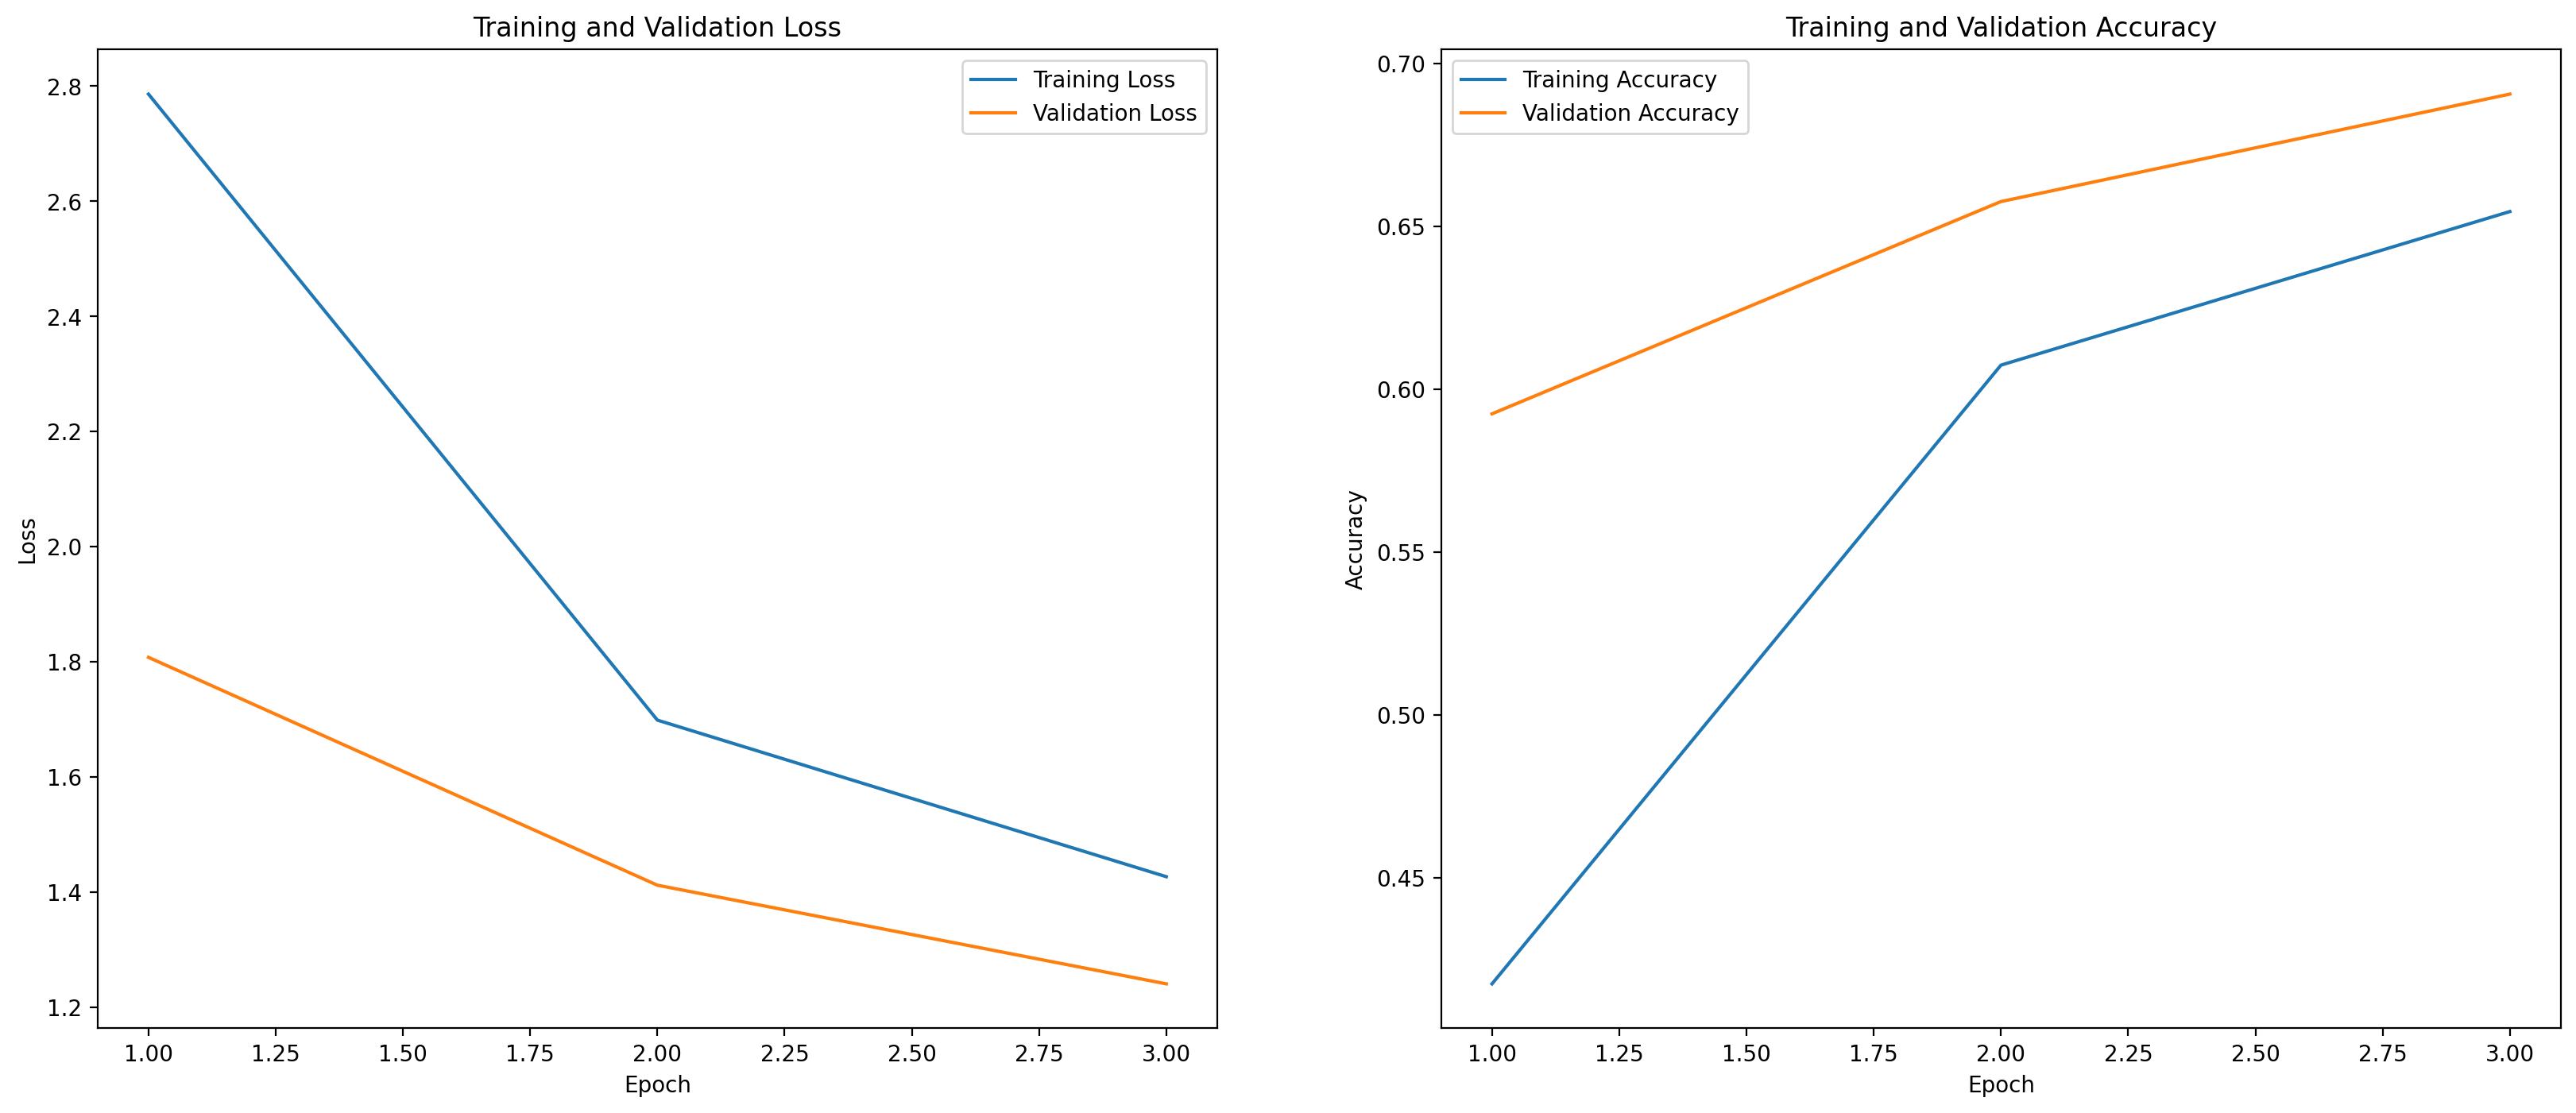

In [22]:
plot.plot_training(results['train_losses'], results['valid_losses'], results['train_accuracies'], results['valid_accuracies'])
plt.show()

In [25]:
engine.test_step??

Signature:
engine.test_step(
    model: torch.nn.modules.module.Module,
    data_loader: torch.utils.data.dataloader.DataLoader,
    loss_fn: torch.nn.modules.module.Module,
    accuracy_fn: torchmetrics.classification.accuracy.Accuracy,
    device: torch.device,
) -> Tuple[torch.Tensor, torch.Tensor]
Docstring: <no docstring>
Source:   
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
    test_loss, test_acc = 0, 0
    model.eval()
    # Turn on inference context manager
    with torch.inference_mode():
        for images, labels in tqdm(data_loader,
                                    total=len(data_loader),
                                    desc='Making predictions:'):

            images, labels= images.to(device), labels.to(device)

            # 1. Forward pass
       

In [26]:
test_loss, test_acc = engine.test_step(model, test_loader, loss_fn, accuracy_fn, device)

Making predictions::   0%|          | 0/790 [00:00<?, ?it/s]

Test loss: 1.08110 | Test accuracy: 0.73


In [27]:
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.081, Test Accuracy: 0.7256
